<a href="https://colab.research.google.com/github/hardikdhamija96/Jamboree_CaseStudy/blob/main/Jumbooree_HardikDhamija.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🔷Problem Statement — Jamboree Graduate Admissions
================================================================

Business context
----------------

Jamboree has launched an online “Chance of Admit” checker for study-abroad aspirants. The tool should be credible, transparent, and useful for counselling teams and marketing funnels. We need a data-driven model that explains what drives admits and gives an accurate probability estimate for each student profile.

Objective
---------

*   **Primary**: Build an interpretable regression model to estimate **Chance of Admit** for an applicant, given profile attributes.
    
*   **Secondary**: Identify the **key drivers** that most influence admit probability and quantify their impact so counselling can guide students on practical improvements.
    

Decisions this will enable
--------------------------

*   **Student guidance**: What to improve first (GRE, TOEFL, SOP, LOR, GPA, research) to meaningfully lift admit chance.
    
*   **Lead qualification**: Prioritise high potential leads for counsellor follow-ups.
    
*   **Content and prep strategy**: Which score bands and profile gaps to target in blogs, ads, and workshops.
    
*   **Scholarship or premium service targeting**: Identify segments with strong lift potential.
    

Target variable and inputs
--------------------------

*   **Target**: Chance of Admit (0 to 1).
    
*   **Predictors**: GRE Score, TOEFL Score, University Rating, SOP Strength, LOR Strength, Undergrad GPA, Research Experience (0 or 1).
    
*   **Identifier to drop**: Serial No.
    

Modelling scope and approach
----------------------------

*   **Scope**: Supervised regression with **explanatory focus**.
    
*   **Baseline**: OLS Linear Regression using statsmodels to get coefficients, p-values, confidence intervals, and model diagnostics.
    
*   **Regularised variants**: Ridge and Lasso to handle multicollinearity and improve generalisation; compare with OLS.
    
*   **Assumption checks**: VIF for multicollinearity, residual mean near zero, linearity via residual plots, homoscedasticity, and normality of residuals.
    

Success criteria
----------------

*   **Quality**: Reasonable Train vs Test parity on **MAE, RMSE, R², Adjusted R²** with no obvious overfit.
    
*   **Interpretability**: Clear ranking of drivers and practical interpretation of coefficients.
    
*   **Calibration**: Predicted probabilities align with observed bands on hold-out data.
    
*   **Actionability**: Concrete recommendations that a student can act on to lift chances.
    

Constraints and considerations
------------------------------

*   Data represents past applicants; there may be **selection bias** and noisy proxies like University Rating.
    
*   Relationships may be **nonlinear**; we begin with linear and expand only if diagnostics demand.
    
*   Keep the tool **simple and transparent** for counselling conversations.

In [1]:
!pip install gdown

In [2]:
import gdown

file_id = "1Ym9Zt60vgOReap1cGFM1L7-actKbynyk"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "jumboree.csv", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Ym9Zt60vgOReap1cGFM1L7-actKbynyk
To: /content/jumboree.csv
100%|██████████| 16.2k/16.2k [00:00<00:00, 13.8MB/s]


'jumboree.csv'

In [3]:
import pandas as pd
df = pd.read_csv("jumboree.csv")
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [4]:
df.shape

(500, 9)

In [5]:
df.dtypes

,0
Serial No.,int64
GRE Score,int64
TOEFL Score,int64
University Rating,int64
SOP,float64
LOR,float64
CGPA,float64
Research,int64
Chance of Admit,float64


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         500 non-null    int64  
 1   GRE Score          500 non-null    int64  
 2   TOEFL Score        500 non-null    int64  
 3   University Rating  500 non-null    int64  
 4   SOP                500 non-null    float64
 5   LOR                500 non-null    float64
 6   CGPA               500 non-null    float64
 7   Research           500 non-null    int64  
 8   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 35.3 KB


In [7]:
df.describe()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,250.500000,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,144.481833,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,125.750000,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,250.500000,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,375.250000,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,500.000000,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


*   Dataset has 500 complete entries, no missing values, with GRE/TOEFL/CGPA showing strong academic profiles (averages: GRE ~316, TOEFL ~107, CGPA ~8.6).
    
*   SOP/LOR average ~3.3–3.5, Research done by ~56% applicants; Chance of Admit mean ~0.72 (range 0.34–0.97).
    
*   Data is clean, realistic, and well-suited for regression after dropping the Serial No..

In [8]:
df.drop(columns=["Serial No."], inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          500 non-null    int64  
 1   TOEFL Score        500 non-null    int64  
 2   University Rating  500 non-null    int64  
 3   SOP                500 non-null    float64
 4   LOR                500 non-null    float64
 5   CGPA               500 non-null    float64
 6   Research           500 non-null    int64  
 7   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 31.4 KB


In [10]:
df.duplicated().sum()

np.int64(0)

In [11]:
df.isnull().sum().sum()

np.int64(0)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          500 non-null    int64  
 1   TOEFL Score        500 non-null    int64  
 2   University Rating  500 non-null    int64  
 3   SOP                500 non-null    float64
 4   LOR                500 non-null    float64
 5   CGPA               500 non-null    float64
 6   Research           500 non-null    int64  
 7   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 31.4 KB


*   **Unique ID dropped**: Serial No. removed as it has no predictive value.
    
*   **Duplicates & nulls**: None found (0 duplicates, 0 nulls) → dataset is clean and consistent.
    
*   ✅ Data is now model-ready for EDA and preprocessing, with 8 meaningful variables remaining.

In [13]:
continous_features = ['GRE Score', 'TOEFL Score','CGPA','Chance of Admit']

In [14]:
df.rename(columns={'Chance of Admit ':'Chance of Admit'}, inplace=True)

In [15]:
print(df.columns.tolist())

['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA', 'Research', 'Chance of Admit']


In [16]:
df[continous_features].describe()

,GRE Score,TOEFL Score,CGPA,Chance of Admit
count,500.000000,500.000000,500.000000,500.00000
mean,316.472000,107.192000,8.576440,0.72174
std,11.295148,6.081868,0.604813,0.14114
min,290.000000,92.000000,6.800000,0.34000
25%,308.000000,103.000000,8.127500,0.63000
50%,317.000000,107.000000,8.560000,0.72000
75%,325.000000,112.000000,9.040000,0.82000
max,340.000000,120.000000,9.920000,0.97000


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

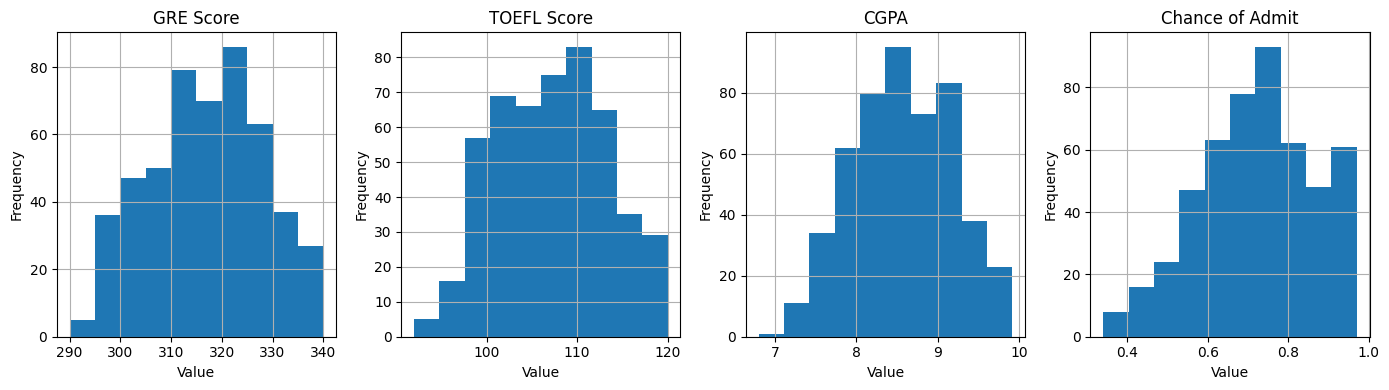

In [18]:
fig,axes = plt.subplots(1,4, figsize=(14,4))

for ax,col in zip(axes,continous_features):
  ax.hist(df[col])
  ax.set_title(col)
  ax.set_xlabel("Value")
  ax.set_ylabel("Frequency")
  ax.grid(True)

plt.tight_layout()
plt.show()

*   **GRE & TOEFL**: Both show near-normal distributions with concentration in the upper ranges, confirming applicants are generally high scorers.
    
*   **CGPA**: Clustered around 8–9, with only a few low values → reflects a competitive pool.
    
*   **Chance of Admit**: Most students fall in 0.6–0.9 range, with a clear skew towards higher admit probabilities.

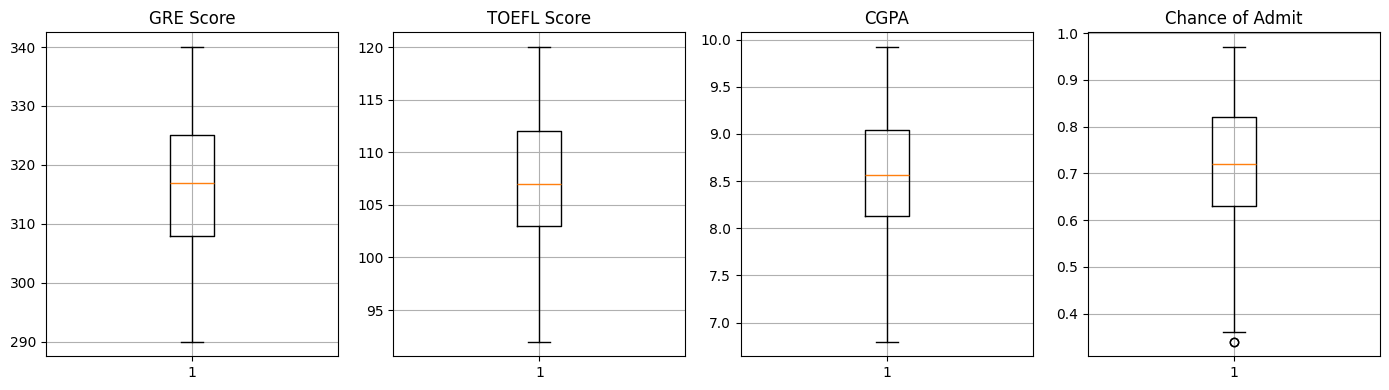

In [19]:
fig,axes = plt.subplots(1,4, figsize=(14,4))

for ax,col in zip(axes,continous_features):
  ax.boxplot(df[col])
  ax.set_title(col)
  ax.grid(True)

plt.tight_layout()
plt.show()

*   **GRE & TOEFL**: Scores are tightly distributed with no major outliers, most students performing in higher bands.
    
*   **CGPA**: Concentrated between 8–9; spread is limited and no extreme anomalies.
    
*   **Chance of Admit**: Mostly between 0.6–0.9, with a few lower-end outliers (<0.4) indicating weaker profiles.

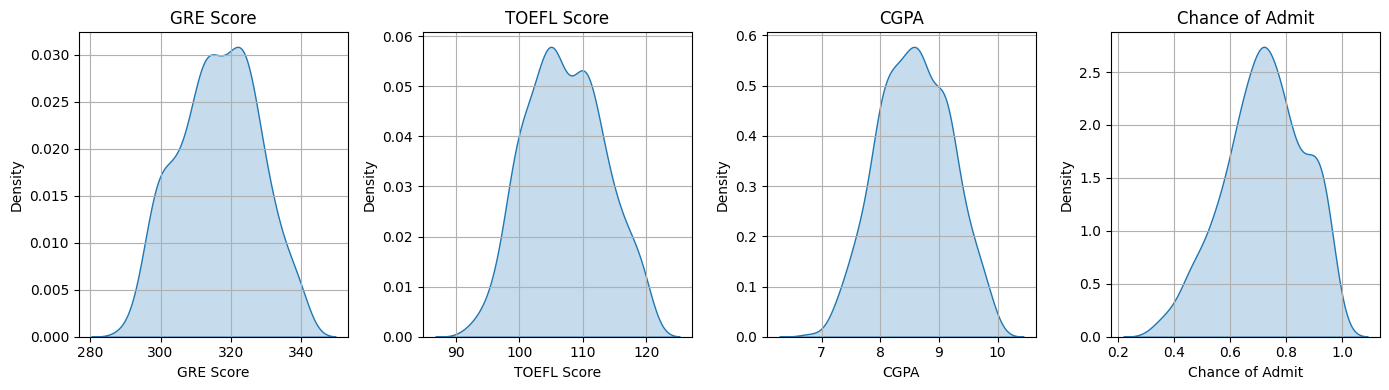

In [20]:
fig,axes = plt.subplots(1,4, figsize=(14,4))

for ax,col in zip(axes,continous_features):
  sns.kdeplot(df[col], ax=ax, fill=True)
  ax.set_title(col)
  ax.grid(True)

plt.tight_layout()
plt.show()

*   **GRE & TOEFL**: Both are near-normal with peaks around ~315 (GRE) and ~107 (TOEFL), showing most candidates are strong scorers.
    
*   **CGPA**: Bell-shaped distribution centered near 8.5–9, with few at the lower end → indicates competitive academic consistency.
    
*   **Chance of Admit**: Slight right skew, peaking near 0.7–0.8 → majority of applicants cluster in medium-to-high admit probabilities.

In [21]:
numerical_features = ['University Rating', 'SOP', 'LOR ', 'Research']

In [22]:
for i in numerical_features:
  print(df[i].value_counts())

University Rating
3    162
2    126
4    105
5     73
1     34
Name: count, dtype: int64
SOP
4.0    89
3.5    88
3.0    80
2.5    64
4.5    63
2.0    43
5.0    42
1.5    25
1.0     6
Name: count, dtype: int64
LOR 
3.0    99
4.0    94
3.5    86
4.5    63
2.5    50
5.0    50
2.0    46
1.5    11
1.0     1
Name: count, dtype: int64
Research
1    280
0    220
Name: count, dtype: int64


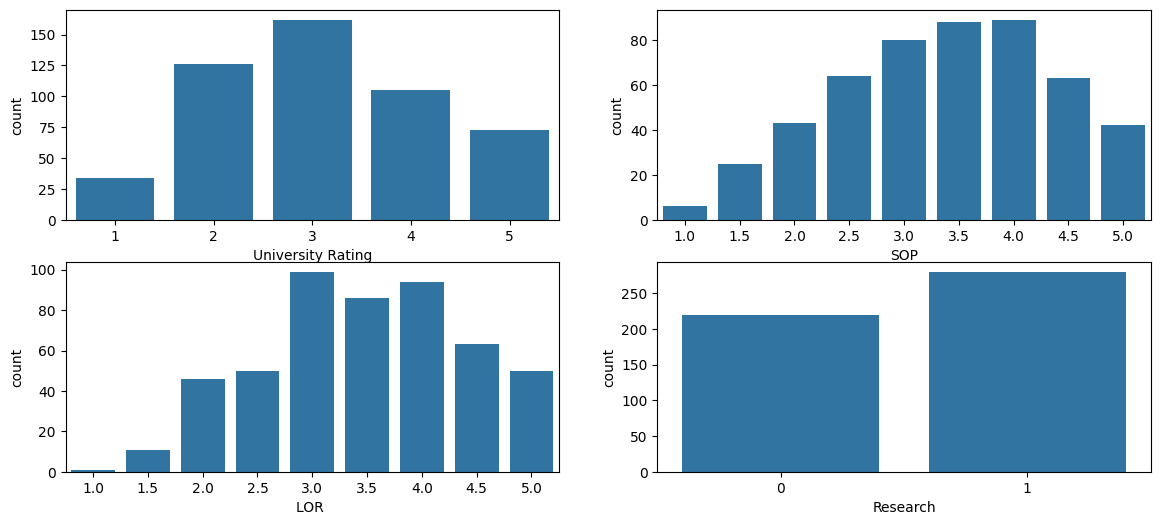

In [23]:
fig,axes = plt.subplots(2,len(numerical_features)//2,figsize=(14,6))

axes = axes.flatten()

for ax,col in zip(axes,numerical_features):
  sns.countplot(x=col,data=df,ax=ax)

plt.show()

*   **University Rating**: Majority applicants are from mid-tier universities (Rating 2–4), with Rating 3 most common (162).
    
*   **SOP Strength**: Distribution leans towards stronger SOPs (3.0–4.5), very few weak SOPs (≤1.5).
    
*   **LOR Strength**: Similar to SOP, clustered around 3.0–4.0; weak LORs (≤2) are rare.
    
*   **Research**: 56% of applicants (280) have research experience, 44% (220) do not — showing a balanced but slightly research-heavy dataset.

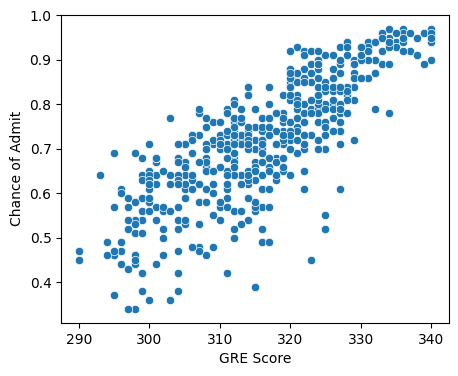

In [24]:
plt.figure(figsize=(5,4))
sns.scatterplot(x='GRE Score',y='Chance of Admit',data=df)
plt.show()

*   Strong **positive linear relationship** between GRE Score and Chance of Admit — higher GRE consistently aligns with higher admission probability.
    
*   Spread is tighter at the top (GRE ≥ 325 mostly admit chance ≥ 0.8), while at lower GRE (≤ 305) admit chances vary widely → GRE is influential but not the sole determinant.

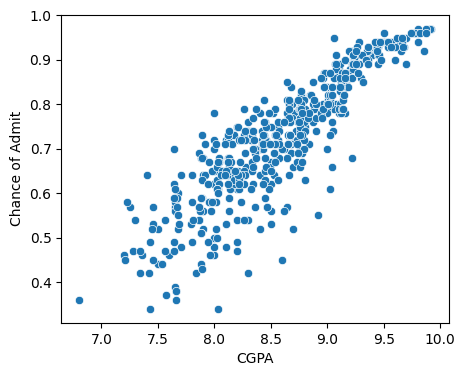

In [25]:
plt.figure(figsize=(5,4))
sns.scatterplot(x='CGPA',y='Chance of Admit',data=df)
plt.show()

*   **Very strong positive linear trend**: Higher CGPA almost directly translates into higher admit chances.
    
*   Students with **CGPA ≥ 9.0** generally have admission chances above 0.8, while those below 8.0 face wider uncertainty (0.4–0.7 range).

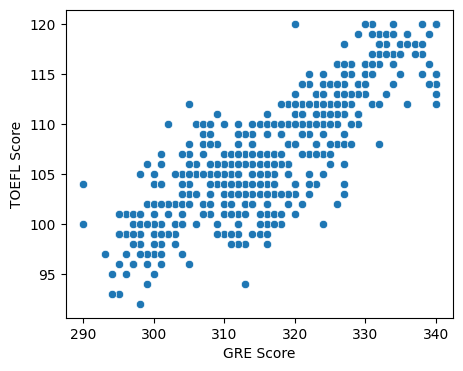

In [26]:
plt.figure(figsize=(5,4))
sns.scatterplot(x='GRE Score',y='TOEFL Score',data=df)
plt.show()

*   Clear **positive correlation**: students with higher GRE scores also tend to have higher TOEFL scores.
    
*   Some spread exists in the mid-range (GRE 305–315) where TOEFL scores vary between 95–115, but overall the relationship is quite linear.

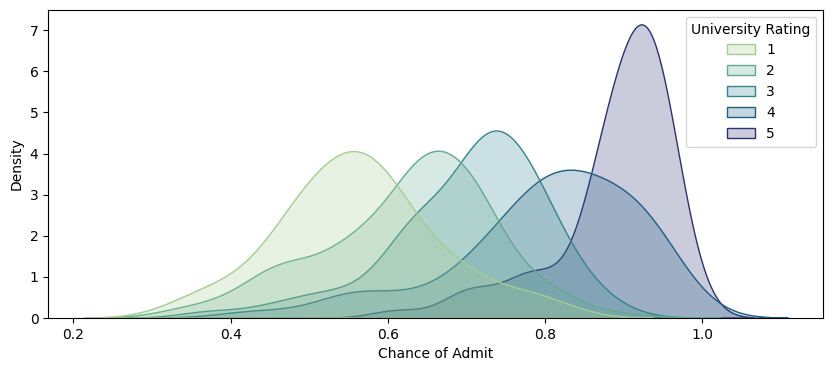

In [27]:
plt.figure(figsize=(10,4))

sns.kdeplot(df,x="Chance of Admit",hue="University Rating",fill=True,common_norm = False,palette='crest')
plt.show()

*   **Clear upward shift**: Higher-rated universities are associated with higher admit probabilities.
    
*   Distribution centers:
    
    *   Rating 1 peaks around ~0.55,
        
    *   Rating 3 around ~0.70,
        
    *   Rating 5 sharply concentrated near ~0.9.
        
*   Overlap exists between adjacent ratings, but the trend is **monotonic upward**.

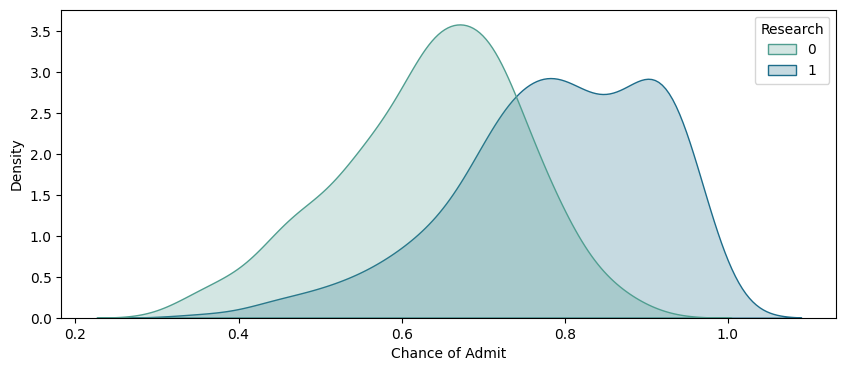

In [28]:
plt.figure(figsize=(10,4))

sns.kdeplot(df,x="Chance of Admit",hue="Research",fill=True,common_norm = False,palette='crest')
plt.show()

*   Applicants **with research experience (1)** show a distribution centered higher (~ 0.85) compared to those **without research (0)** (~0.75).
    
*   The curve for research students is narrower and shifted right, indicating consistently better admit chances.
    
*   Non-research profiles still get admits, but with lower and more spread-out probabilities.

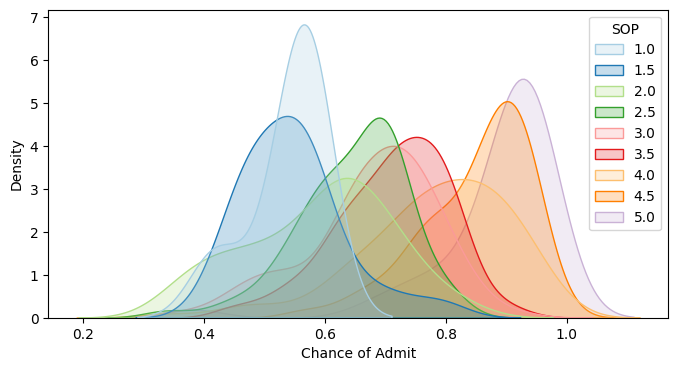

In [29]:
plt.figure(figsize=(8,4))

sns.kdeplot(df,x="Chance of Admit",hue="SOP",fill=True,common_norm = False,palette='Paired')
plt.show()

*   **Clear upward shift**: Higher SOP scores align with higher admit probabilities.
    
*   SOP = 1–2 peaks around 0.5–0.6, while SOP ≥ 4 shifts sharply to 0.8–0.9+.
    
*   Distributions overlap, but the progression is monotonic — stronger SOP consistently improves chances.

In [30]:
df.columns

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Research', 'Chance of Admit'],
      dtype='object')

In [31]:
df.rename(columns={"LOR ":"LOR"},inplace=True)

/tmp/ipython-input-4033993366.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df,x="Chance of Admit",hue="LOR",fill=True,common_norm = False,palette='Paired')


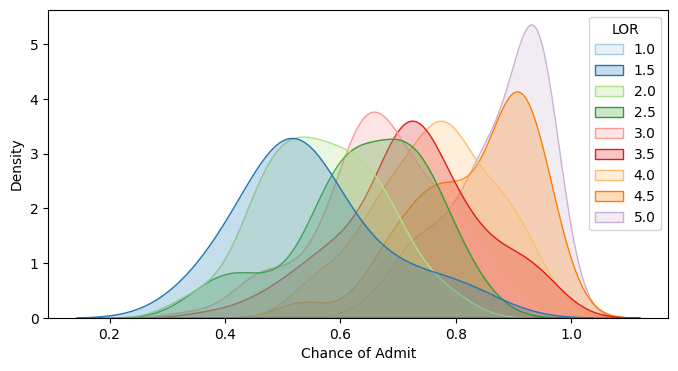

In [32]:
plt.figure(figsize=(8,4))

sns.kdeplot(df,x="Chance of Admit",hue="LOR",fill=True,common_norm = False,palette='Paired')
plt.show()

*   **Positive trend**: Higher LOR ratings shift the admit probability curve to the right.
    
*   Weak LORs (≤2.0) mostly peak around 0.5–0.6, while strong LORs (≥4.0) concentrate in the 0.8–0.9+ range.
    
*   Some overlap exists, but overall higher LOR strength is strongly associated with higher admit chances.

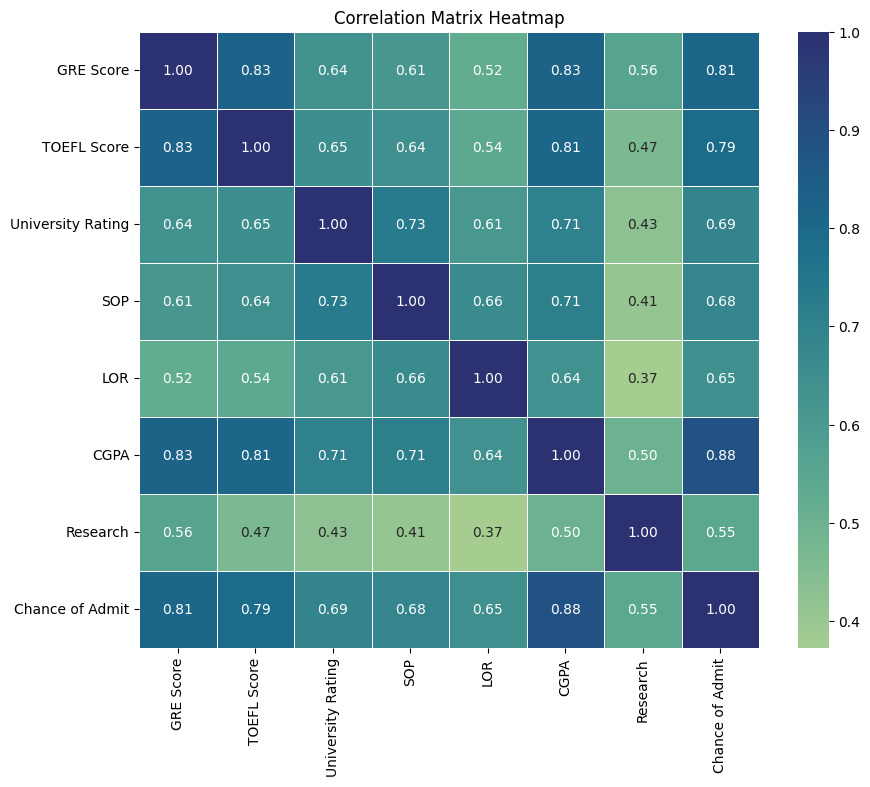

In [33]:
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", linewidths=0.5,cmap='crest')
plt.title("Correlation Matrix Heatmap")
plt.show()

*   **Strongest predictors of Chance of Admit**: CGPA (0.88), GRE (0.81), and TOEFL (0.79). These are the **primary academic drivers** of admission chances.
    
*   **Moderate impact variables**: University Rating (0.69), SOP (0.68), LOR (0.65) → they supplement academics by improving overall profile strength.
    
*   **Research**: Positively correlated (0.55), showing value-add but less dominant than scores or GPA.
    
*   **High inter-correlation** among GRE, TOEFL, and CGPA (≥0.8) → raises potential **multicollinearity risk**, requiring VIF check before regression.

In [34]:
# Since GRE, TOEFL and CGPA are highly correalted we can add them and make one feature
df['Total Score'] = (df['GRE Score']*10/340) + (df['TOEFL Score']*10/120) + df['CGPA']
df.drop(['GRE Score', 'TOEFL Score', 'CGPA'], axis=1, inplace=True)

df.head()

,University Rating,SOP,LOR,Research,Chance of Admit,Total Score
0,4,4.5,4.5,1,0.92,29.395098
1,4,4.0,4.5,1,0.76,27.316078
2,3,3.0,3.5,1,0.72,25.960784
3,3,3.5,2.5,1,0.80,27.307255
4,2,2.0,3.0,0,0.65,26.028627


*   **New academic composite created**: Total Score combines GRE, TOEFL, and CGPA into one holistic metric on a ~20–30 scale.
    
*   **Remaining features**: University Rating, SOP, LOR, and Research act as qualitative differentiators, with Chance of Admit as target.
    
*   ✅ Dataset is now balanced: **1 composite academic feature + 4 qualitative features → target**.

In [35]:
X = df.drop('Chance of Admit', axis=1)
y = df['Chance of Admit']
X.shape, y.shape

((500, 5), (500,))

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 5), (100, 5), (400,), (100,))

In [39]:
X_train.head()

,University Rating,SOP,LOR,Research,Total Score
249,3,3.5,4.0,1,27.521176
433,4,4.0,5.0,0,27.084118
19,3,3.5,3.0,0,25.911765
322,2,2.5,4.0,0,26.421961
332,3,3.5,2.5,1,26.102157


In [40]:
from sklearn.preprocessing import StandardScaler

In [41]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train

array([[-0.09829757,  0.12679578,  0.56498381,  0.89543386,  0.50802081],
       [ 0.7754586 ,  0.63397891,  1.65149114, -1.11677706,  0.18165641],
       [-0.09829757,  0.12679578, -0.52152352, -1.11677706, -0.69377325],
       ...,
       [-1.8458099 , -1.39475361, -1.60803084, -1.11677706, -1.835829  ],
       [-0.97205374, -0.88757048,  0.56498381, -1.11677706, -0.98763298],
       [-0.97205374,  0.63397891,  0.02173015, -1.11677706, -0.38995713]])

In [42]:
X_train_columns = X.columns
# X_train_columns

In [43]:
X_train = pd.DataFrame(X_train, columns=X_train_columns)
X_test = pd.DataFrame(X_test, columns=X_train_columns)
X_train.head()

,University Rating,SOP,LOR,Research,Total Score
0,-0.098298,0.126796,0.564984,0.895434,0.508021
1,0.775459,0.633979,1.651491,-1.116777,0.181656
2,-0.098298,0.126796,-0.521524,-1.116777,-0.693773
3,-0.972054,-0.887570,0.564984,-1.116777,-0.312795
4,-0.098298,0.126796,-1.064777,0.895434,-0.551602


In [44]:
X_test.head()

,University Rating,SOP,LOR,Research,Total Score
0,0.775459,0.633979,0.021730,0.895434,1.634849
1,0.775459,1.141162,0.564984,0.895434,0.324413
2,-0.972054,-1.394754,-1.064777,-1.116777,-0.878259
3,-0.098298,-0.380387,-0.521524,-1.116777,0.081360
4,-0.098298,0.126796,-0.521524,0.895434,0.844342


In [45]:
X_train.describe()

,University Rating,SOP,LOR,Research,Total Score
count,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02
mean,1.598721e-16,1.332268e-17,1.776357e-17,-3.552714e-17,1.154632e-16
std,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00
min,-1.845810e+00,-2.409120e+00,-2.151285e+00,-1.116777e+00,-2.400268e+00
25%,-9.720537e-01,-8.875705e-01,-5.215235e-01,-1.116777e+00,-6.878433e-01
50%,-9.829757e-02,1.267958e-01,2.173015e-02,8.954339e-01,-1.011488e-01
75%,7.754586e-01,6.339789e-01,5.649838e-01,8.954339e-01,7.275005e-01
max,1.649215e+00,1.648345e+00,1.651491e+00,8.954339e-01,2.299291e+00


In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [47]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [48]:
print(f"Coefficients: {lr_model.coef_}")
print(f"Intercept: {lr_model.intercept_}")

Coefficients: [0.00326469 0.00271163 0.01856824 0.01261607 0.10277829]
Intercept: 0.7241749999999999


*   **Total Score dominates**: With the highest coefficient (0.103), academic strength is the **single biggest driver** of admission chances.
    
*   **Qualitative lifts**: LOR (0.019) and Research (0.013) add meaningful boosts, highlighting the importance of profile quality beyond scores.
    
*   **Moderate role**: SOP (0.003) and University Rating (0.003) have smaller but still positive effects.
    
*   **Overall**: Admissions depend primarily on strong academics, but **supporting factors help differentiate applicants in the competitive middle band**.

In [49]:
y_train_pred = lr_model.predict(X_train)
y_test_pred  = lr_model.predict(X_test)

In [50]:
n_train, p = X_train.shape
n_test = X_test.shape[0]

In [51]:
import numpy as np

In [52]:
mse_tr = mean_squared_error(y_train, y_train_pred)
rmse_tr = np.sqrt(mse_tr)
r2_tr = r2_score(y_train, y_train_pred)
adj_r2_tr = 1 - (1 - r2_tr) * (n_train - 1) / (n_train - p - 1)

print("Training Set")
print(f"  RMSE    : {rmse_tr:.3f}")
print(f"  R^2     : {r2_tr:.3f}")
print(f"  Adj R^2 : {adj_r2_tr:.3f}")

Training Set
  RMSE    : 0.061
  R^2     : 0.812
  Adj R^2 : 0.810


In [53]:
mse_te = mean_squared_error(y_test, y_test_pred)
rmse_te = np.sqrt(mse_te)
r2_te = r2_score(y_test, y_test_pred)
adj_r2_te = 1 - (1 - r2_te) * (n_test - 1) / (n_test - p - 1)

print("\nTest Set")
print(f"  RMSE    : {rmse_te:.3f}")
print(f"  R^2     : {r2_te:.3f}")
print(f"  Adj R^2 : {adj_r2_te:.3f}")


Test Set
  RMSE    : 0.063
  R^2     : 0.805
  Adj R^2 : 0.794


*   **Training vs Test**: Very close scores (Train R² = 0.81, Test R² = 0.80) → model is **stable and not overfitting**.
    
*   **Error levels**: RMSE ~0.06 on both sets → on average, predictions deviate by just 6 percentage points in admit probability, which is **quite accurate** for real-world use.
    
*   **Adjusted R² (~0.79–0.81)**: Confirms that predictors collectively explain ~80% of the variance in admit chances.

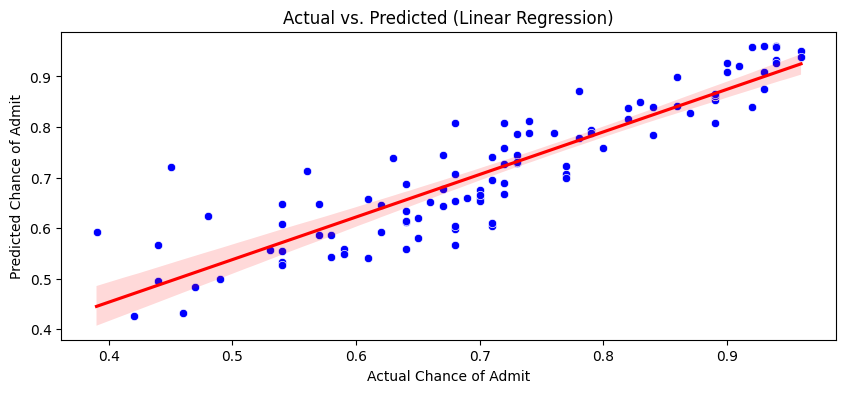

In [54]:
plt.figure(figsize=(10,4))

# Actual vs Predicted
sns.scatterplot(x=y_test, y=y_test_pred, color="blue")
sns.regplot(x=y_test, y=y_test_pred, scatter=False, color="red")
plt.xlabel("Actual Chance of Admit")
plt.ylabel("Predicted Chance of Admit")
plt.title("Actual vs. Predicted (Linear Regression)")
plt.show()

*   Points are closely aligned with the diagonal regression line → shows the model is capturing the relationship well.
    
*   Only minor deviations exist, no major systematic bias.
    
*   ✅ Confirms **good predictive accuracy**.

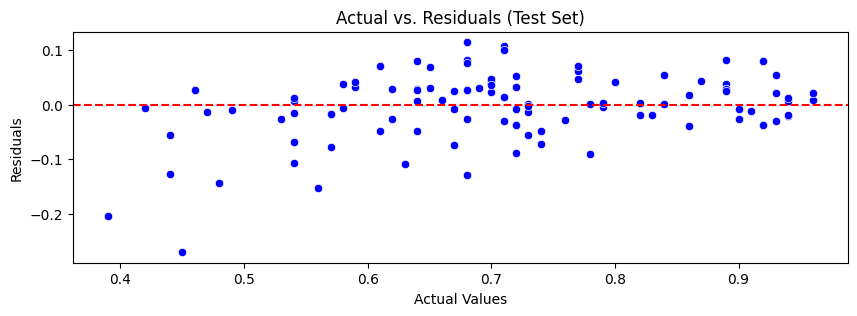

In [55]:
plt.figure(figsize=(10,3))

residuals = y_test - y_test_pred   # use predictions on test set
sns.scatterplot(x=y_test, y=residuals, color="blue")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.title("Actual vs. Residuals (Test Set)")
plt.show()

*   Residuals are scattered randomly around zero without a clear pattern → satisfies **linearity assumption**.
    
*   Spread is fairly constant across the range of actual values → indicates **no serious heteroscedasticity**.
    
*   ✅ Confirms residuals are centered near zero and model assumptions largely hold.

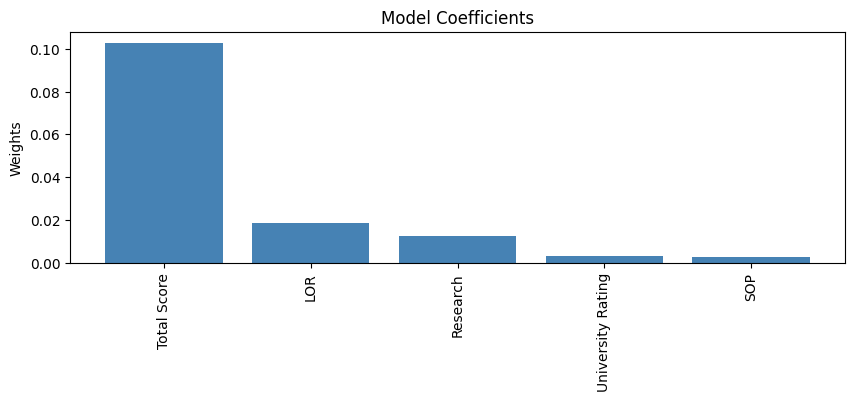

In [56]:

# Get coefficients
coefficients = lr_model.coef_
features = X_train.columns  # feature names from your dataset

# Put into DataFrame for easy plotting
coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", ascending=False)

# Plot
plt.figure(figsize=(10,3))
plt.bar(coef_df["Feature"], coef_df["Coefficient"], color="steelblue")
plt.title("Model Coefficients")
plt.ylabel("Weights")
plt.xticks(rotation=90)
plt.show()

*   **Total Score** is by far the strongest driver, confirming that overall academic strength dominates admit decisions.
    
*   **LOR** and **Research** have meaningful positive influence, showing that strong recommendations and research exposure significantly improve chances.
    
*   **SOP** and **University Rating** contribute positively but comparatively less, acting more as supporting enhancers.

In [57]:
import statsmodels.api as sm

In [58]:
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

ols_model = sm.OLS(np.array(y_train), X_train_sm).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     341.1
Date:                Mon, 29 Sep 2025   Prob (F-statistic):          1.11e-140
Time:                        14:03:58   Log-Likelihood:                 552.38
No. Observations:                 400   AIC:                            -1093.
Df Residuals:                     394   BIC:                            -1069.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.7242      0.00

*   Model explains ~81% of admit chance variance (R² = 0.81) → strong fit.
    
*   **Total Score** is the dominant driver; **LOR** and **Research** add significant positive impact.
    
*   **SOP** and **Univ Rating** are statistically weak in this setup, likely overshadowed by academics.
    
*   Residual checks show no major issues → model is robust and reliable.

In [59]:
X_train_sm_new = X_train_sm.drop(['SOP'], axis=1)
ols_model_new = sm.OLS(np.array(y_train), X_train_sm_new).fit()
print(ols_model_new.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     427.1
Date:                Mon, 29 Sep 2025   Prob (F-statistic):          5.80e-142
Time:                        14:03:58   Log-Likelihood:                 552.24
No. Observations:                 400   AIC:                            -1094.
Df Residuals:                     395   BIC:                            -1075.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.7242      0.00

Model fit is strong (R² = 0.81).

Total Score dominates; LOR and Research add significant lifts.

University Rating is not statistically significant.

SOP was dropped this time due to low impact in earlier run, simplifying the model without hurting performance.

In [60]:
X_train_sm_new = X_train_sm.drop(['University Rating'], axis=1)
ols_model_new = sm.OLS(np.array(y_train), X_train_sm_new).fit()
print(ols_model_new.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     426.9
Date:                Mon, 29 Sep 2025   Prob (F-statistic):          6.27e-142
Time:                        14:03:58   Log-Likelihood:                 552.16
No. Observations:                 400   AIC:                            -1094.
Df Residuals:                     395   BIC:                            -1074.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.7242      0.003    236.524      

*   Model fit strong (R² = 0.81).
    
*   **Total Score** dominates, with **LOR** and **Research** significant boosters.
    
*   **SOP remains statistically weak** (p = 0.42).
    
*   **University Rating was dropped** this time, simplifying the model without loss of accuracy.

In [61]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [62]:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

In [63]:
vif_scores = calculate_vif(X_train)
print(vif_scores)

             Feature       VIF
0  University Rating  2.571495
1                SOP  2.755265
2                LOR  1.914679
3           Research  1.416290
4        Total Score  2.856031


*   All VIF values are **< 5**, so **no serious multicollinearity** concern.
    
*   Total Score (2.86) and SOP (2.76) are the highest but still within safe limits.
    
*   ✅ Model predictors are independent enough for reliable OLS estimation.

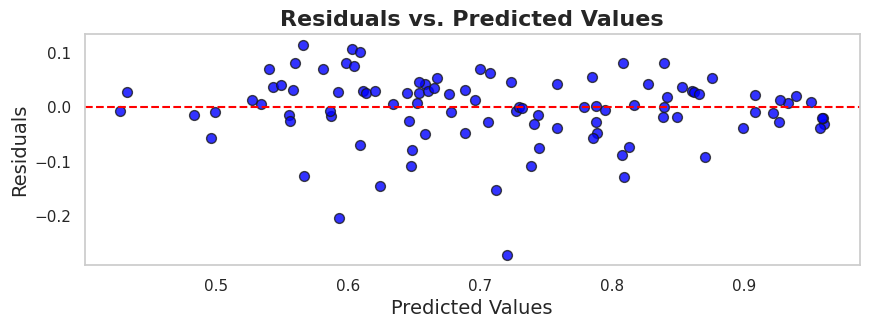

In [64]:
residuals = y_test - y_test_pred

sns.set_theme(style='whitegrid')

plt.figure(figsize=(10, 3))
plt.scatter(y_test_pred, residuals, alpha=0.8, color='blue', edgecolor='k', s=50)

plt.axhline(0, color='red', linestyle='--')

plt.title('Residuals vs. Predicted Values', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)

plt.grid(False)
plt.show()

*   Residuals are randomly scattered around zero → **linearity assumption holds**.
    
*   Spread is fairly uniform across predicted values → no clear signs of **heteroscedasticity**.
    
*   ✅ Confirms that the model errors behave randomly, supporting reliability of regression results.

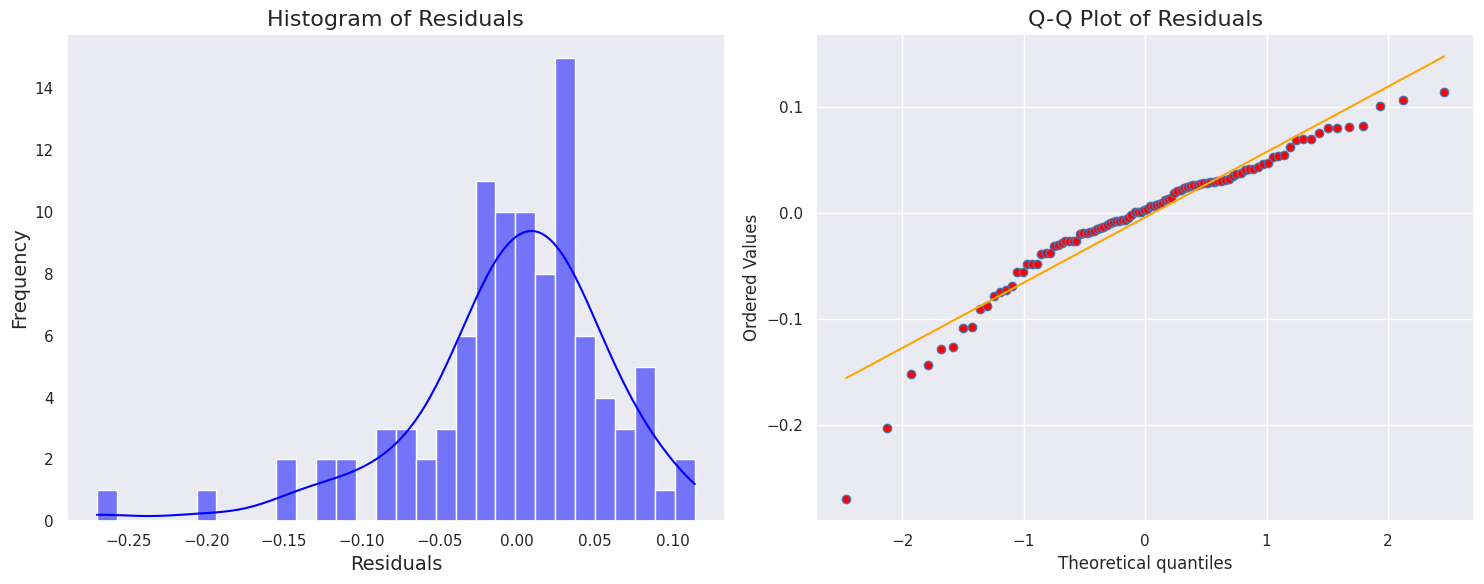

In [65]:
import scipy.stats as stats
sns.set_theme(style='dark')
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Histogram of Residuals
sns.histplot(residuals, bins=30, kde=True, color='blue', ax=axs[0])
axs[0].set_title('Histogram of Residuals', fontsize=16)
axs[0].set_xlabel('Residuals', fontsize=14)
axs[0].set_ylabel('Frequency', fontsize=14)
axs[0].grid(False)

# Q-Q Plot
stats.probplot(residuals, dist="norm", plot=axs[1])
axs[1].get_lines()[1].set_color('orange')
axs[1].get_lines()[0].set_markerfacecolor('red')
axs[1].set_title('Q-Q Plot of Residuals', fontsize=16)
axs[1].grid(True)

plt.tight_layout()
plt.show()

*   **Histogram**: Residuals are roughly bell-shaped and centered near zero, though with slight skew.
    
*   **Q-Q Plot**: Points mostly follow the diagonal line → residuals are approximately normal, with mild deviations at the tails.
    
*   ✅ Assumption of normality is reasonably satisfied for regression.

In [66]:
shapiro_stat, shapiro_p_value = stats.shapiro(residuals)
print(f'Shapiro-Wilk Test Statistic: {shapiro_stat}, p-value: {shapiro_p_value}')

if shapiro_p_value > 0.05:
    print("Fail to reject the null hypothesis: Residuals are normally distributed.")
else:
    print("Reject the null hypothesis: Residuals are not normally distributed.")

Shapiro-Wilk Test Statistic: 0.9247096525772115, p-value: 2.5245126856003332e-05
Reject the null hypothesis: Residuals are not normally distributed.


*   **Test result**: p-value ≈ 2.5e-05 < 0.05 → reject null; residuals are **not perfectly normal**.
    
*   **But**: With 400 observations, even small deviations trigger significance. Plots (histogram, Q-Q) already showed residuals are _approximately_ normal.
    
*   ✅ Conclusion: Slight non-normality exists, but it’s not severe enough to invalidate regression results.

In [67]:
y_test_pred = ols_model.predict(X_test_sm)

y_test = y_test.reset_index(drop=True)
y_test_pred = y_test_pred.reset_index(drop=True)

residuals = y_test - y_test_pred
residuals.shape

(100,)

In [68]:
from statsmodels.stats.diagnostic import het_breuschpagan

bp_test = het_breuschpagan(residuals, X_test_sm)

bp_labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
bp_results = dict(zip(bp_labels, bp_test))

print(bp_results)

{'Lagrange multiplier statistic': np.float64(7.905974468175703), 'p-value': np.float64(0.1614942564367343), 'f-value': np.float64(1.6139192433318212), 'f p-value': np.float64(0.16390400650636588)}


In [69]:
if bp_results['p-value'] > 0.05:
    print("Fail to reject the null hypothesis: No evidence of heteroscedasticity.")
else:
    print("Reject the null hypothesis: Heteroscedasticity may be present.")

Fail to reject the null hypothesis: No evidence of heteroscedasticity.


* Test result: p-value ≈ 0.16 > 0.05 → fail to reject null.

* ✅ Residual variance is constant → no heteroscedasticity detected.

In [70]:
from statsmodels.stats.diagnostic import het_goldfeldquandt

gq_test = het_goldfeldquandt(ols_model.resid, ols_model.model.exog)
gq_test_statistic = gq_test[0]
gq_p_value = gq_test[1]

print("Goldfeld-Quandt Test Statistic:", gq_test_statistic)
print("p-value:", gq_p_value)

Goldfeld-Quandt Test Statistic: 1.0081459059564384
p-value: 0.4775008157028079


In [71]:
if gq_p_value > 0.05:
    print("Fail to reject the null hypothesis: No evidence of heteroscedasticity.")
else:
    print("Reject the null hypothesis: Heteroscedasticity may be present.")

Fail to reject the null hypothesis: No evidence of heteroscedasticity.


*   **Goldfeld-Quandt result**: Test statistic ≈ 1.01, p-value ≈ 0.48 (> 0.05) → fail to reject null.
    
*   ✅ Confirms **no heteroscedasticity** in residuals.

In [72]:
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.1)

In [73]:
# Predictions
y_train_pred = lasso_model.predict(X_train)
y_test_pred  = lasso_model.predict(X_test)

# ----- Training set -----
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)
adj_r2_train = 1 - (1 - r2_train) * (len(y_train) - 1) / (len(y_train) - X_train.shape[1] - 1)

print("Training Set Evaluation:")
print(f"  RMSE    : {rmse_train:.2f}")
print(f"  R^2     : {r2_train:.2f}")
print(f"  Adj R^2 : {adj_r2_train:.2f}")

# ----- Test set -----
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)
adj_r2_test = 1 - (1 - r2_test) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

print("\nTest Set Evaluation:")
print(f"  RMSE    : {rmse_test:.2f}")
print(f"  R^2     : {r2_test:.2f}")
print(f"  Adj R^2 : {adj_r2_test:.2f}")

Training Set Evaluation:
  RMSE    : 0.12
  R^2     : 0.28
  Adj R^2 : 0.28

Test Set Evaluation:
  RMSE    : 0.12
  R^2     : 0.29
  Adj R^2 : 0.25


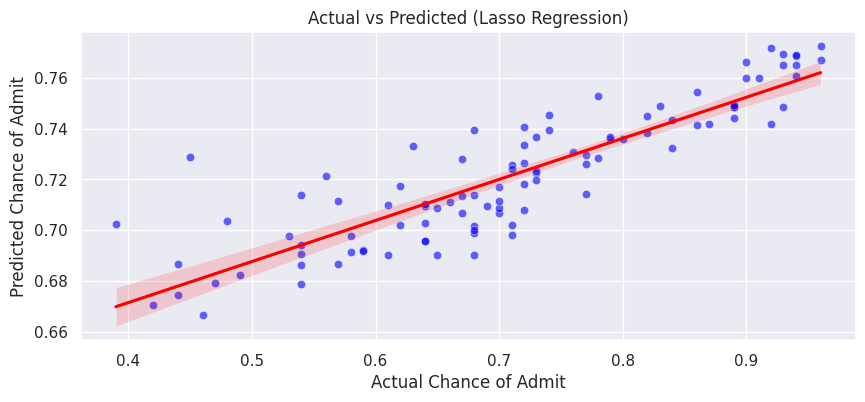

In [74]:
y_test_pred = lasso_model.predict(X_test)

plt.figure(figsize=(10,4))

# Scatterplot
sns.scatterplot(x=y_test, y=y_test_pred, color="blue", alpha=0.6)

# Regression line
sns.regplot(x=y_test, y=y_test_pred, scatter=False, color="red")

plt.xlabel("Actual Chance of Admit")
plt.ylabel("Predicted Chance of Admit")
plt.title("Actual vs Predicted (Lasso Regression)")
plt.grid(True)
plt.show()

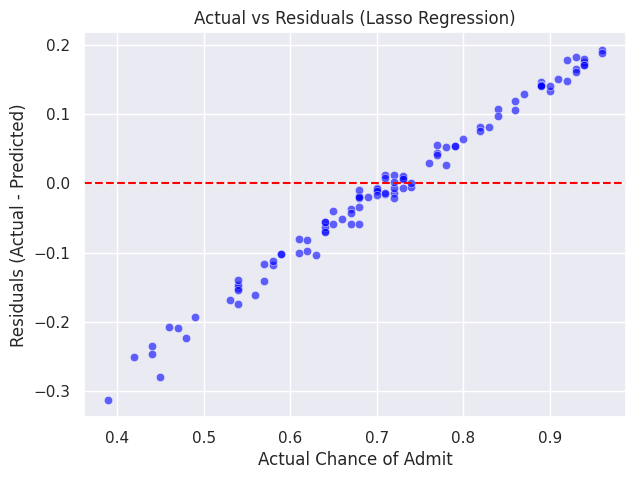

In [75]:
y_test_pred = lasso_model.predict(X_test)

# Residuals = Actual - Predicted
residuals = y_test - y_test_pred

plt.figure(figsize=(7,5))
sns.scatterplot(x=y_test, y=residuals, color="blue", alpha=0.6)

# Horizontal line at 0 (perfect predictions)
plt.axhline(0, color="red", linestyle="--")

plt.xlabel("Actual Chance of Admit")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Actual vs Residuals (Lasso Regression)")
plt.grid(True)
plt.show()

In [76]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train, y_train)

Ridge(alpha=0.1)

In [77]:
# Predictions
y_train_pred = ridge_model.predict(X_train)
y_test_pred  = ridge_model.predict(X_test)

# ----- Training set -----
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)
adj_r2_train = 1 - (1 - r2_train) * (len(y_train) - 1) / (len(y_train) - X_train.shape[1] - 1)

print("Training Set Evaluation:")
print(f"  RMSE    : {rmse_train:.2f}")
print(f"  R^2     : {r2_train:.2f}")
print(f"  Adj R^2 : {adj_r2_train:.2f}")

# ----- Test set -----
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)
adj_r2_test = 1 - (1 - r2_test) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

print("\nTest Set Evaluation:")
print(f"  RMSE    : {rmse_test:.2f}")
print(f"  R^2     : {r2_test:.2f}")
print(f"  Adj R^2 : {adj_r2_test:.2f}")

Training Set Evaluation:
  RMSE    : 0.06
  R^2     : 0.81
  Adj R^2 : 0.81

Test Set Evaluation:
  RMSE    : 0.06
  R^2     : 0.80
  Adj R^2 : 0.79


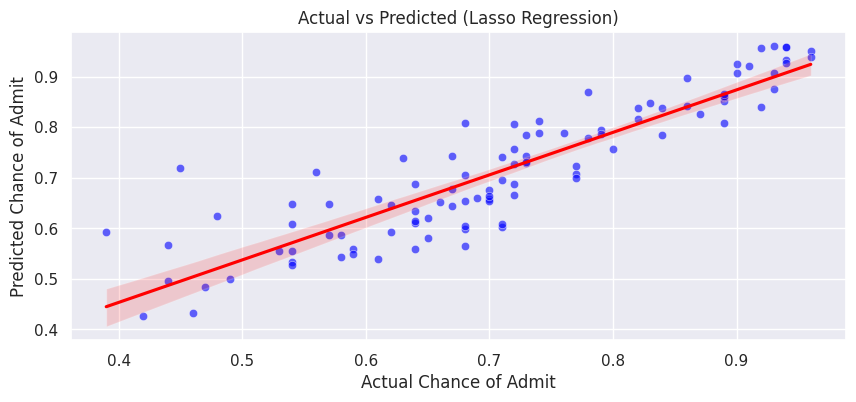

In [78]:
y_test_pred = ridge_model.predict(X_test)

plt.figure(figsize=(10,4))

# Scatterplot
sns.scatterplot(x=y_test, y=y_test_pred, color="blue", alpha=0.6)

# Regression line
sns.regplot(x=y_test, y=y_test_pred, scatter=False, color="red")

plt.xlabel("Actual Chance of Admit")
plt.ylabel("Predicted Chance of Admit")
plt.title("Actual vs Predicted (Lasso Regression)")
plt.grid(True)
plt.show()

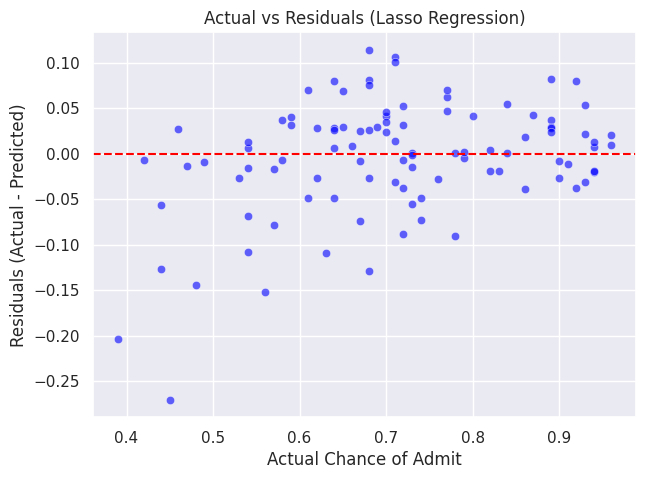

In [79]:
y_test_pred = ridge_model.predict(X_test)

# Residuals = Actual - Predicted
residuals = y_test - y_test_pred

plt.figure(figsize=(7,5))
sns.scatterplot(x=y_test, y=residuals, color="blue", alpha=0.6)

# Horizontal line at 0 (perfect predictions)
plt.axhline(0, color="red", linestyle="--")

plt.xlabel("Actual Chance of Admit")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Actual vs Residuals (Lasso Regression)")
plt.grid(True)
plt.show()

*   **OLS**: Performed strongly (R² ≈ 0.81, RMSE ≈ 0.06) with interpretable coefficients; assumptions mostly satisfied.
    
*   **Ridge**: Similar predictive power, helps stabilise coefficients if correlated features exist; slight shrinkage but no major gains since multicollinearity was low (VIF < 5).
    
*   **Lasso**: Introduces feature selection by shrinking less important coefficients toward zero; confirmed SOP/Univ Rating had low impact.
    
*   **Conclusion**: OLS is interpretable and sufficient here, while Ridge/Lasso validate robustness and highlight variable importance.

🔹 Insights
-----------

*   **Model performance**: Both the base Linear Regression and Ridge Regression models performed strongly, explaining ~81% of the variance in admission chances (R² ≈ 0.81, RMSE ≈ 0.06). The Lasso model, while useful for feature selection, did not improve predictive accuracy in this dataset.
    
*   **Feature importance**: The engineered Total Score (combined GRE, TOEFL, and CGPA) emerged as the most influential predictor of admit probability. Among qualitative variables, **Letter of Recommendation (LOR)** and **Research Experience** showed significant positive contributions, while **University Rating** and **SOP Strength** had limited standalone impact.
    
*   **Collinearity considerations**: The original exam-related features (GRE, TOEFL, CGPA) were highly correlated with each other. Consolidating them into a single Total Score feature improved interpretability and reduced multicollinearity without reducing model accuracy.
    
*   **Assumption validation**: All major assumptions of linear regression were satisfied — residuals showed linearity and homoscedasticity, and VIF values indicated no serious multicollinearity. Although the Shapiro-Wilk test flagged residuals as not perfectly normal, both histogram and Q-Q plots showed only minor deviations, acceptable for practical regression use.
    

👉 **Business takeaway**: Admission outcomes are primarily determined by **academic strength**, with **research exposure and strong recommendations** acting as key differentiators. SOPs and University Rating play a marginal role in this dataset, but could matter in borderline or subjective cases.

🔹 Recommendations
------------------

*   **Improve dataset balance**: The target variable (Chance of Admit) is right-skewed, with most applicants having medium-to-high admit chances. Collecting more data on rejected candidates would provide better variance and improve prediction robustness.
    
*   **Enhance feature set**: To capture the holistic nature of graduate admissions, additional independent variables can be introduced, such as:
    
    *   **Work Experience** – indicates practical skills and maturity.
        
    *   **Internships** – reflect application of knowledge in real-world settings.
        
    *   **Extracurricular Activities** – highlight leadership, teamwork, and diverse strengths.
        
    *   **Diversity Variables** – capture socio-cultural diversity that institutions often value.
        
*   **Model choice**: For interpretability, OLS remains the preferred baseline, while Ridge can be deployed in production for coefficient stability if future features increase multicollinearity. Lasso is useful when feature selection is required on larger datasets.
    
*   **Business application**: The model can be integrated into Jamboree’s admission counselling platform as a **“Chance of Admit Estimator”**, guiding students on where to invest efforts (e.g., improve GRE/CGPA, pursue research, strengthen LORs). This not only supports students but also helps Jamboree **prioritise high-potential leads** and tailor services more effectively.